In [217]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50,preprocess_input,decode_predictions
from keras.preprocessing import image
from keras.models import Model,load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input,Dropout,Dense,Embedding,LSTM,GRU,merge,BatchNormalization,concatenate
from keras.layers.merge import add
import collections
from math import log
from keras.applications.inception_v3 import InceptionV3
from keras.layers.wrappers import Bidirectional
from nltk.translate.bleu_score import corpus_bleu
from keras.models import Sequential
from keras_lstm_attention_glove840b import Attention
from keras.models import load_model

In [2]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [3]:
captions = readTextFile("FlickerTextData/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]
print(len(captions))

40460


In [4]:
IMG_PATH = "Flicker8k_Dataset"

### Data Preparation and Preprocessing

In [5]:
# creating dict of captions with their images
descriptions = {}
for c in captions:
    first,second = c.split('\t')
    imgName = first.split('.')[0]
    
    if descriptions.get(imgName) is None:
        descriptions[imgName] = []
    descriptions[imgName].append(second)

In [6]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

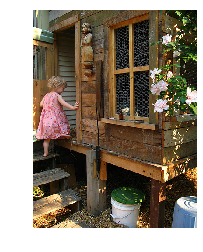

In [7]:
img = plt.imread(IMG_PATH+"/1000268201_693b08cb0e.jpg")
#img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

In [8]:
# Removing punctuations and words of lengtrh 1
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    #print(sentence)
    sentence = [s for s in sentence if len(s) > 1]
    sentence = " ".join(sentence)
    return sentence

In [9]:
clean_text("A little girl climbing the stairs to her playhouse .")

'little girl climbing the stairs to her playhouse'

In [10]:
# cleaning dict
for key,capList in descriptions.items():
    for i in range (len(capList)):
        capList[i] = clean_text(capList[i])

In [11]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [12]:
with open("descriptions.txt","w") as f:
    f.write(str(descriptions))

In [13]:
# reading stored file
descriptions = None
with open("descriptions.txt",'r') as f:
    descriptions = f.read()
    
correct_string = descriptions.replace("'","\"") ######################################
descriptions = json.loads(correct_string)     

In [14]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [15]:
# vocab of unique words
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print(len(vocab))

8424


In [16]:
# total_words in dict
total_words = []
for key in descriptions.keys():
    [total_words.append(i) for desc in descriptions[key] for i in desc.split()]

print(len(total_words))

373837


In [17]:
# Gives freq of unique words
counter = collections.Counter(total_words)
freq_cnt = dict(counter)

In [18]:
# filtering to reduce vocab size
sorted_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])
threshold = 10
sorted_cnt = [sf for sf in sorted_cnt if sf[1] > threshold ]
total_words = [x[0] for x in sorted_cnt]

### Prepare Train/Test Data

In [19]:
train_file = readTextFile("FlickerTextData/Flickr_8k.trainImages.txt")
test_file = readTextFile("FlickerTextData/Flickr_8k.testImages.txt")

In [20]:
train_data = [row.split(".")[0] for row in train_file.split('\n')[:-1]]
test_data = [row.split(".")[0] for row in test_file.split('\n')[:-1]]

In [21]:
train_data[0]

'2513260012_03d33305cf'

In [22]:
train_descriptions_for_acc = {}
for img_id in train_data:
    train_descriptions_for_acc[img_id] = []
    for caption in descriptions[img_id]:
        #cap_added = "startseq " + caption + " endseq"
        train_descriptions_for_acc[img_id].append(caption)
        #train_descriptions[img_id].append(cap_added)

In [23]:
train_descriptions = {}
for img_id in train_data:
    train_descriptions[img_id] = []
    for caption in descriptions[img_id]:
        cap_added = "startseq " + caption + " endseq"
        train_descriptions[img_id].append(cap_added)

In [24]:
train_descriptions_for_acc["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

### Captions preprocessing

In [25]:
word2idx = {}
idx2word = {}

for i,word in enumerate(total_words):
    word2idx[word] = i+1       # using 0 index for words that are not present in the feature vector
    idx2word[i+1] = word

In [26]:
word2idx["startseq"] = 1846
idx2word[1846] = "startseq"
word2idx["endseq"] = 1847
idx2word[1847] = "endseq"

vocabSize = len(word2idx) + 1
print(vocabSize)

1848


In [27]:
maxLen = 0

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        maxLen = max(maxLen,len(cap.split()))

print(maxLen)

35


In [28]:
# data Generator
def data_generator(train_descriptions,encoded_train,word2idx,maxLen,batchSize):
    X1,X2,y = [],[],[]
    
    n = 0
    while True:
        for key,descList in train_descriptions.items():
            n+=1
            photo = encoded_train[key]
            for cap in descList:
                seq = [word2idx[word] for word in cap.split() if word in word2idx]
                
                for i in range(len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    xi = pad_sequences([xi],maxlen=maxLen,value=0,padding="post")[0]
                    yi = to_categorical([yi],num_classes=vocabSize)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    
                    y.append(yi)
                
                if n == batchSize:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n= 0
                    

### Word Embeddings

In [29]:
f = open("glove.6B.50d.txt",encoding='utf8')

In [30]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:],dtype="float")
    embedding_index[word] = word_embedding
f.close()

In [31]:
embedding_index["apple"]

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [32]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocabSize,emb_dim))
    for word,idx in word2idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
         
    return matrix

In [33]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [34]:
#embedding_matrix[1845]

### Image Processing

In [107]:
def preprocess_img_resnet(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0) ##################
    
    img = preprocess_input(img) ###############
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


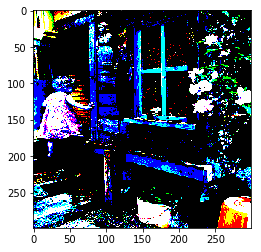

In [108]:
img = preprocess_img_resnet(IMG_PATH+"/1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.show()

In [ ]:
def preprocess_img_inception(img):
    img = image.load_img(img,target_size=(299,299))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0) ##################
    
    img = preprocess_input(img) ###############
    return img

In [ ]:
img = preprocess_img_inception(IMG_PATH+"/1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.show()

## Method 1 - using ResNet50

In [37]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
_____________________________________

In [41]:
new_model = Model(model.input,model.layers[-2].output)

In [96]:
def encode_img(img):
    img = preprocess_img_resnet(img)
    feature_vector = new_model.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [97]:
encode_img("Flicker8k_Dataset/1000268201_693b08cb0e.jpg")

array([0.04154462, 0.17075884, 0.2927681 , ..., 0.05094037, 0.31319624,
       0.8600727 ], dtype=float32)

In [ ]:
# images -->  feature vector encoded from Resnet50 - TRAIN
encoding_train = {}
for ix,img_id in enumerate(train_data):
    img_path = IMG_PATH + "/"+img_id+".jpg"
    encoding_train[img_id] = encode_img(img_path)
    
    if(ix%100 == 0):
        print("Encoding train progress at %d"%ix)

In [ ]:
with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [ ]:
# images -->  feature vector encoded from Resnet50 - TEST
encoding_test = {}
for ix,img_id in enumerate(test_data):
    img_path = IMG_PATH + "/"+img_id+".jpg"
    encoding_test[img_id] = encode_img(img_path)
    
    if(ix%100 == 0):
        print("Encoding test progress at %d"%ix)

In [ ]:
with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

### Model Architecture 1

In [46]:
#images as input
input_image_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_image_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [47]:
#captions as input
input_captions = Input(shape=(maxLen,))
inp_cap1 = Embedding(input_dim=vocabSize,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)


In [48]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocabSize,activation='softmax')(decoder2)

In [49]:
model = Model(inputs=[input_image_features,input_captions],outputs=outputs)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 35, 50)       92400       input_5[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 2048)         0           input_4[0][0]                    
__________________________________________________________________________________________________
dropout_4 

In [50]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [51]:
model.compile(loss='categorical_crossentropy',optimizer = "adam")

### Training - 1

In [52]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

In [53]:
def train():
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word2idx,maxLen,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

In [ ]:
train()

## Method 2 - using InceptionV3

In [109]:
model_inception = InceptionV3(weights="imagenet",input_shape=(299,299,3))
model_inception.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, 149, 149, 32) 864         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_191 (BatchN (None, 149, 149, 32) 96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_238 (Activation)     (None, 149, 149, 32) 0           batch_normalization_191[0][0]    
__________________________________________________________________________________________________
conv2d_190

In [110]:
new_inceptionV_model = Model(model_inception.input,model_inception.layers[-2].output)

In [114]:
def encode_img_incept(img):
    img = preprocess_img_inception(img)
    feature_vector = new_inceptionV_model.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [112]:
encode_img_incept("Flicker8k_Dataset/1000268201_693b08cb0e.jpg")

(2048,)


array([ 0.02582967,  0.19295248, 16.72615   , ...,  1.5267365 ,
        6.1464415 ,  2.0506117 ], dtype=float32)

In [115]:
# images -->  feature vector encoded from InceptionV3q - TRAIN
encoding_train_inceptionV = {}
for ix,img_id in enumerate(train_data):
    img_path = IMG_PATH + "/"+img_id+".jpg"
    encoding_train_inceptionV[img_id] = encode_img_incept(img_path)
    
    if(ix%100 == 0):
        print("Encoding train progress at %d"%ix)

Encoding train progress at 0
Encoding train progress at 100
Encoding train progress at 200
Encoding train progress at 300
Encoding train progress at 400
Encoding train progress at 500
Encoding train progress at 600
Encoding train progress at 700
Encoding train progress at 800
Encoding train progress at 900
Encoding train progress at 1000
Encoding train progress at 1100
Encoding train progress at 1200
Encoding train progress at 1300
Encoding train progress at 1400
Encoding train progress at 1500
Encoding train progress at 1600
Encoding train progress at 1700
Encoding train progress at 1800
Encoding train progress at 1900
Encoding train progress at 2000
Encoding train progress at 2100
Encoding train progress at 2200
Encoding train progress at 2300
Encoding train progress at 2400
Encoding train progress at 2500
Encoding train progress at 2600
Encoding train progress at 2700
Encoding train progress at 2800
Encoding train progress at 2900
Encoding train progress at 3000
Encoding train progr

In [116]:
with open("encoded_train_inceptionV_features.pkl","wb") as f:
    pickle.dump(encoding_train_inceptionV,f)

In [117]:
# images -->  feature vector encoded from Resnet50 - TEST
encoding_test_inceptionV = {}
for ix,img_id in enumerate(test_data):
    img_path = IMG_PATH + "/"+img_id+".jpg"
    encoding_test_inceptionV[img_id] = encode_img_incept(img_path)
    
    if(ix%100 == 0):
        print("Encoding test progress at %d"%ix)

Encoding test progress at 0
Encoding test progress at 100
Encoding test progress at 200
Encoding test progress at 300
Encoding test progress at 400
Encoding test progress at 500
Encoding test progress at 600
Encoding test progress at 700
Encoding test progress at 800
Encoding test progress at 900


In [118]:
with open("encoded_test_inceptionV_features.pkl","wb") as f:
    pickle.dump(encoding_test_inceptionV,f)

### Model Architecture - 2

In [165]:
#images as input
input_image_features = Input(shape=(2048,))
inp_img1 = Dropout(0.5)(input_image_features)
# inp_img2 = BatchNormalization()(inp_img1)
inp_img2 = Dense(256,activation='relu')(inp_img1)


In [166]:
#captions as input
input_captions = Input(shape=(maxLen,))
inp_cap1 = Embedding(input_dim=vocabSize,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.5)(inp_cap1)
inp_cap3 = BatchNormalization()(inp_cap2)
inp_cap4 = Bidirectional(LSTM(128,return_sequences=True))(inp_cap3)

In [167]:
decoder1 = add([inp_img2,inp_cap4])
decoder2 = Bidirectional(LSTM(128,return_sequences=False))(decoder1)
decoder3 = Dense(256,activation='relu')(decoder2)
outputs = Dense(vocabSize,activation='softmax')(decoder3)

In [168]:
model_inceptionV = Model(inputs=[input_image_features,input_captions],outputs=outputs)
model_inceptionV.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 35)           0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 35, 50)       92400       input_24[0][0]                   
__________________________________________________________________________________________________
input_23 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
dropout_20 (Dropout)            (None, 35, 50)       0           embedding_10[0][0]               
__________________________________________________________________________________________________
dropout_19

In [169]:
model_inceptionV.layers[1].set_weights([embedding_matrix])
model_inceptionV.layers[1].trainable = False
model_inceptionV.compile(loss='categorical_crossentropy',optimizer = "adam")

### Training - 2

In [173]:
epochs = 30
batch_size = 120
steps = len(train_descriptions)//batch_size

In [174]:
def train_2():
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train_inceptionV,word2idx,maxLen,batch_size)
        model_inceptionV.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model_inceptionV.save('./model_weights_inceptionV3/model_'+str(i)+'.h5')

In [208]:
train_2()

### Model Architecture - 3

In [156]:
#images as input
input_image_features = Input(shape=(2048,))
inp_img1 = Dropout(0.4)(input_image_features)
# inp_img2 = BatchNormalization()(inp_img1)
inp_img2 = Dense(256,activation='relu')(inp_img1)


#captions as input
input_captions = Input(shape=(maxLen,))
inp_cap1 = Embedding(input_dim=vocabSize,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.4)(inp_cap1)
inp_cap3 = BatchNormalization()(inp_cap2)
inp_cap4 = Bidirectional(GRU(128,return_sequences=True))(inp_cap3)
inp_cap5 = Attention(maxLen)(inp_cap4)

In [157]:
decoder1 = add([inp_img2,inp_cap5])
#decoder2 = Bidirectional(LSTM(128,return_sequences=False))(decoder1)
decoder3 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocabSize,activation='softmax')(decoder3)

In [160]:
model_attention = Model(inputs=[input_image_features,input_captions],outputs=outputs)
model_attention.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 35)           0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 35, 50)       92400       input_22[0][0]                   
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 35, 50)       0           embedding_9[0][0]                
__________________________________________________________________________________________________
input_21 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
batch_norm

In [161]:
model_attention.layers[1].set_weights([embedding_matrix])
model_attention.layers[1].trainable = False
model_attention.compile(loss='categorical_crossentropy',optimizer = "adam")

### Training - 3

In [176]:
epochs = 10
batch_size = 120
steps = len(train_descriptions)//batch_size

In [177]:
def train_3():
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word2idx,maxLen,batch_size)
        model_attention.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model_attention.save('./model_weights_attention/model_'+str(i+20)+'.h5')

In [178]:
train_3()

Epoch 1/1
50/50 [==============================] - 901s 18s/step - loss: 2.6067
Epoch 1/1
50/50 [==============================] - 883s 18s/step - loss: 2.5850
Epoch 1/1
50/50 [==============================] - 892s 18s/step - loss: 2.5654
Epoch 1/1
50/50 [==============================] - 780s 16s/step - loss: 2.5477
Epoch 1/1
50/50 [==============================] - 580s 12s/step - loss: 2.5278
Epoch 1/1
50/50 [==============================] - 629s 13s/step - loss: 2.5088
Epoch 1/1
50/50 [==============================] - 698s 14s/step - loss: 2.4898
Epoch 1/1
50/50 [==============================] - 628s 13s/step - loss: 2.4758
Epoch 1/1
50/50 [==============================] - 653s 13s/step - loss: 2.4620
Epoch 1/1
50/50 [==============================] - 673s 13s/step - loss: 2.4467


### Loading Encoding_Test and Model

In [209]:
model = load_model('model_weights/model_1.h5')

In [210]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 35)           0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 35, 50)       92400       input_11[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 2048)         0           input_10[0][0]                   
__________________________________________________________________________________________________
dropout_10

In [181]:
with open('encoded_test_features.pkl', 'rb') as f:
    encoding_test = pickle.load(f)

In [216]:
with open('encoded_test_inceptionV_features.pkl', 'rb') as f:
    encoding_testinceptionV_ = pickle.load(f)

In [171]:
with open('encoded_train_features.pkl', 'rb') as f:
    encoding_train_features = pickle.load(f)

In [89]:
with open('encoded_train_inceptionV_features.pkl', 'rb') as f:
    encoding_train_inceptionV = pickle.load(f)

### Predicting Output

### For Method 1 - ResNet50 + LSTM

#### using Greedy Search

In [164]:
def predict_captions(testImg):
    input_text = "startseq"
    for i in range(maxLen):
        seq = [word2idx[w] for w in input_text.split() if w in word2idx]
        seq = pad_sequences([seq],maxlen=maxLen,padding='post')
        yPred = model.predict([testImg,seq])
        yPred = yPred.argmax()
        word = idx2word[yPred]
        input_text += (' ' + word)
        if word == 'endseq':
            break
    output_caption = input_text.split()[1:-1]
    output_caption = ' '.join(output_caption)
    
    return output_caption

basketball player in blue jersey is trying to block him


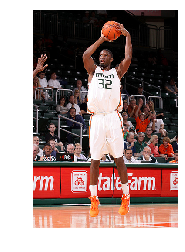

man kayaking in the ocean


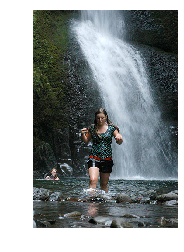

boy in blue shirt and blue shorts hits ball in field


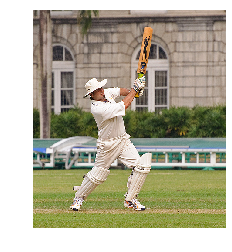

three dogs are playing in the snow


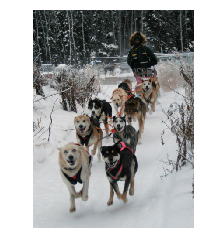

two dogs are running in the grass


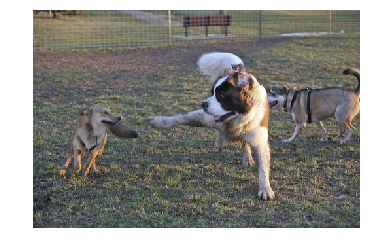

man in green helmet riding his bike on dirt path


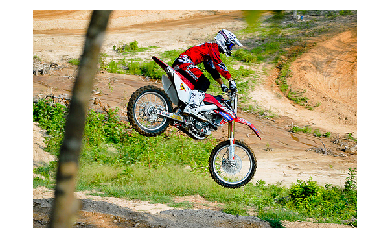

little boy in blue shirt is eating his mouth


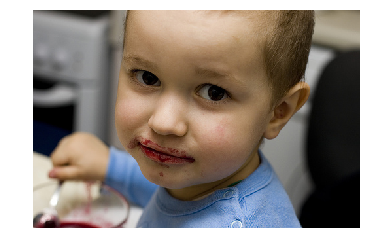

young girl in swimsuit is playing in the sprinklers


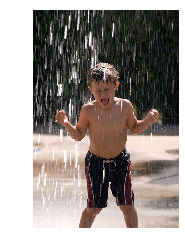

two young boys are playing football in front of house


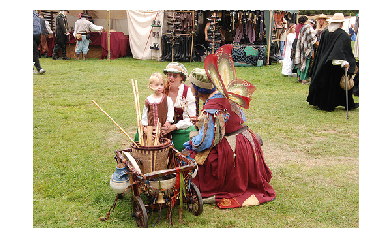

two dogs are playing with ball in third


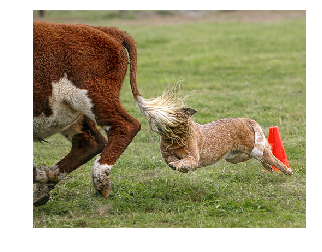

In [165]:
for i in range(10):
    num = np.random.randint(0,1000)
    test_image_list = list(encoding_test.keys())
    test_image_name = test_image_list[num]
    photo = encoding_test[test_image_name].reshape((1,2048))
    
    result = plt.imread(IMG_PATH + "/" + test_image_name +".jpg")
    caption = predict_captions(photo)
    
    plt.axis("off")
    plt.imshow(result)
    print(caption)
    plt.show()

#### using Beam Search

In [213]:
def beam_search_predictions_attention(image, beam_index = 5):
    begin = [word2idx["startseq"]]
    sequences = [[begin, 0.0]]
    
    for i in range(maxLen):
        temp = []
        for s in sequences:
            par_caps = pad_sequences([s[0]], maxlen=maxLen, padding='post')
            preds = model.predict([image,par_caps]) 
            # Getting the top <beam_index>(n) predictions
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # creating a new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        sequences = temp
        # Sorting according to the probabilities
        sequences = sorted(sequences, reverse=False, key=lambda x: x[1])
        # Getting the top words
        sequences = sequences[-beam_index:]
    
    sequences = sequences[-1][0]
    temp_caption = [idx2word[i] for i in sequences]

    caption = []
    
    for i in temp_caption:
        if i != 'endseq':
            caption.append(i)
        else:
            break
    
    caption = ' '.join(caption[1:])
    return caption

child in winter gear is riding through the snow


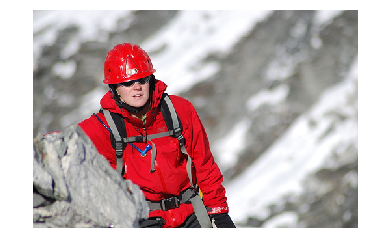

the man in the white shirt is playing guitar


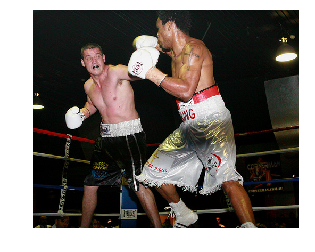

man in red shirt is standing in front of brick wall


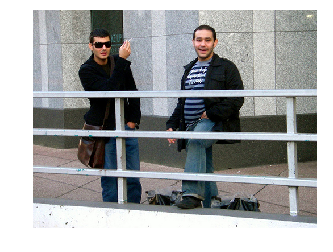

two dogs wrestle in the grass


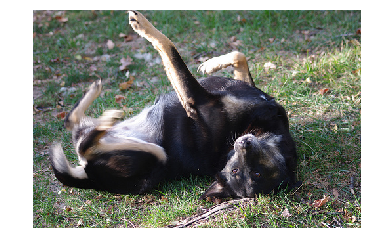

man and woman are standing in front of an art structure


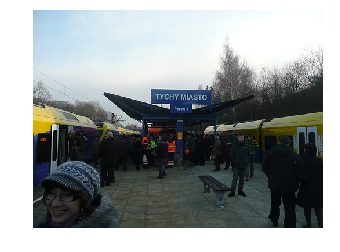

In [214]:
for i in range(5):
    num = np.random.randint(0,1000)
    test_image_list = list(encoding_test.keys())
    test_image_name = test_image_list[num]
    photo = encoding_test[test_image_name].reshape((1,2048))
    
    result = plt.imread(IMG_PATH + "/" + test_image_name +".jpg")
    caption = beam_search_predictions(photo)
    print(caption)  
    plt.axis("off")
    plt.imshow(result)
    plt.show()

### For Method 3 - Attention model

#### Using Greedy Search

In [183]:
def predict_captions_attention(testImg):
    input_text = "startseq"
    for i in range(maxLen):
        seq = [word2idx[w] for w in input_text.split() if w in word2idx]
        seq = pad_sequences([seq],maxlen=maxLen,padding='post')
        yPred = model_attention.predict([testImg,seq])
        yPred = yPred.argmax()
        word = idx2word[yPred]
        input_text += (' ' + word)
        if word == 'endseq':
            break
    output_caption = input_text.split()[1:-1]
    output_caption = ' '.join(output_caption)
    
    return output_caption

girl in red dress and tight her arm


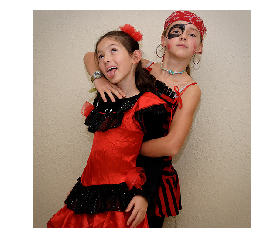

dog is running through water


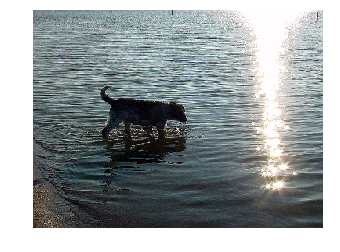

dog with red collar is running through the grass


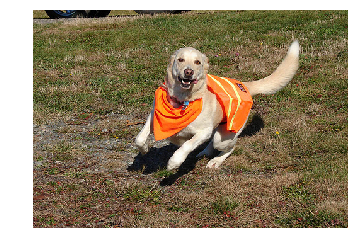

brown dog is biting brown dog in the grass


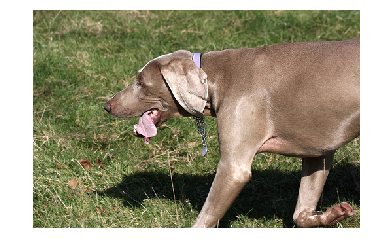

black and white dog is running through the grass


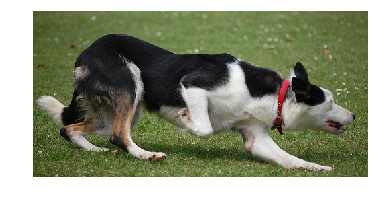

In [184]:
for i in range(5):
    num = np.random.randint(0,1000)
    test_image_list = list(encoding_test.keys())
    test_image_name = test_image_list[num]
    photo = encoding_test[test_image_name].reshape((1,2048))
    
    result = plt.imread(IMG_PATH + "/" + test_image_name +".jpg")
    caption = predict_captions_attention(photo)
    
    plt.axis("off")
    plt.imshow(result)
    print(caption)
    plt.show()

#### Using Beam Search

In [202]:
def beam_search_predictions_attention(image, beam_index = 5):
    begin = [word2idx["startseq"]]
    sequences = [[begin, 0.0]]
    
    for i in range(maxLen):
        temp = []
        for s in sequences:
            par_caps = pad_sequences([s[0]], maxlen=maxLen, padding='post')
            preds = model_attention.predict([image,par_caps]) 
            # Getting the top <beam_index>(n) predictions
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # creating a new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        sequences = temp
        # Sorting according to the probabilities
        sequences = sorted(sequences, reverse=False, key=lambda x: x[1])
        # Getting the top words
        sequences = sequences[-beam_index:]
    
    sequences = sequences[-1][0]
    temp_caption = [idx2word[i] for i in sequences]

    caption = []
    
    for i in temp_caption:
        if i != 'endseq':
            caption.append(i)
        else:
            break
    
    caption = ' '.join(caption[1:])
    return caption


little boy plays with toy in the background


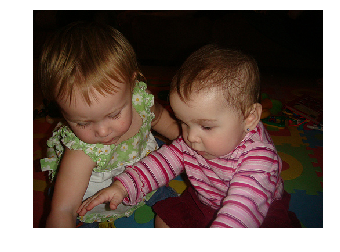

small child plays with the camera in the woods


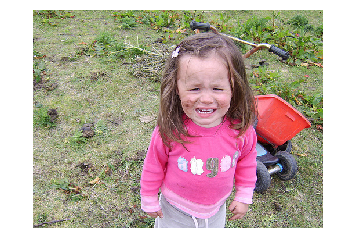

white dog runs through the water


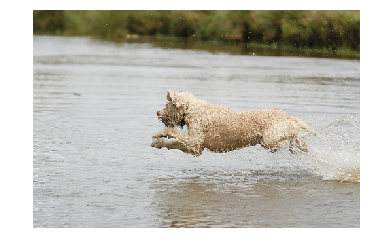

brown and white dog is running through the grass


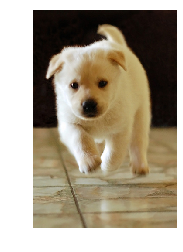

young boy in blue shirt is standing on ledge with his arms raised it


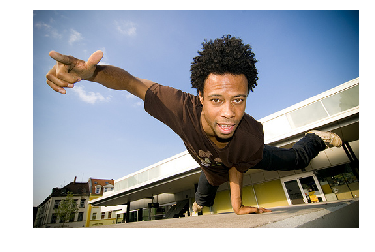

child in red jacket is smiling in the middle of her shoulders


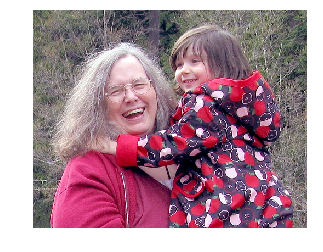

girl in red shirt is standing on top of grassy field


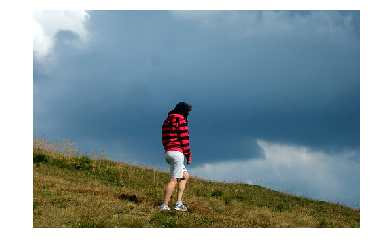

small child is playing with toys in its mouth


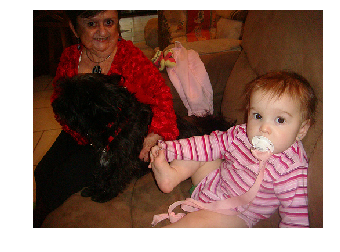

the brown dog is trying to be at the top of its hind legs in its mouth


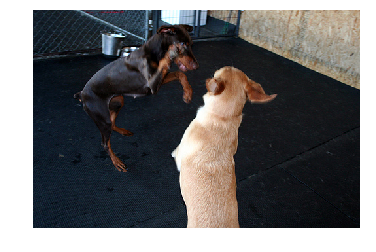

the black dog is running through the grass


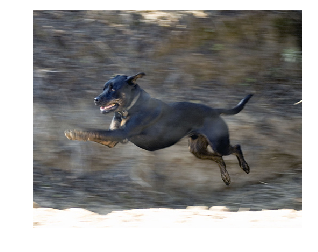

In [203]:
for i in range(10):
    num = np.random.randint(0,1000)
    test_image_list = list(encoding_test.keys())
    test_image_name = test_image_list[num]
    photo = encoding_test[test_image_name].reshape((1,2048))
    
    result = plt.imread(IMG_PATH + "/" + test_image_name +".jpg")
    caption = beam_search_predictions_attention(photo)
    print(caption)  
    plt.axis("off")
    plt.imshow(result)
    plt.show()

### Calculating Accuracy

### For Method 1 - ResNet50 + LSTM

#### For Greedy Search

In [64]:
actual,predicted = list(), list()
def evaluate():
    #actual,predicted = list(), list()
    counter = 0
    for key,desc_list in train_descriptions_for_acc.items():
        photo = encoding_train[key].reshape((1,2048))
        result = plt.imread(IMG_PATH + "/" + key +".jpg")
        caption = predict_captions(photo)
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(caption.split())
        if(counter % 500 == 0):
            print("Example %d"% counter)
        counter+=1;
    print("\n SCORE: ")    
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [65]:
evaluate()

Example 0
Example 500
Example 1000
Example 1500
Example 2000
Example 2500
Example 3000
Example 3500
Example 4000
Example 4500
Example 5000
Example 5500

 SCORE: 
BLEU-1: 0.517207
BLEU-2: 0.328283
BLEU-3: 0.241923
BLEU-4: 0.128629


#### For Beam Search

In [260]:
actual,predicted = list(), list()
def evaluate_beam():
    #actual,predicted = list(), list()
    counter = 0
    for key,desc_list in train_descriptions_for_acc.items():
        photo = encoding_train[key].reshape((1,2048))
        result = plt.imread(IMG_PATH + "/" + key +".jpg")
        caption = beam_search_predictions(photo,7)
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(caption.split())
        if(counter % 250 == 0):
            print("Example %d"% counter)
        counter+=1;
    print("\n SCORE: ")    
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [261]:
evaluate_beam()

Example 0
Example 250
Example 500
Example 750
Example 1000
Example 1250
Example 1500
Example 1750
Example 2000
Example 2250
Example 2500
Example 2750
Example 3000
Example 3250
Example 3500
Example 3750
Example 4000
Example 4250
Example 4500
Example 4750
Example 5000
Example 5250
Example 5500
Example 5750

 SCORE: 
BLEU-1: 0.491441
BLEU-2: 0.325767
BLEU-3: 0.251638
BLEU-4: 0.139356


### For Method 1 - ResNet50 + LSTM

In [186]:
actual,predicted = list(), list()
def evaluate_attention():
    #actual,predicted = list(), list()
    counter = 0
    for key,desc_list in train_descriptions_for_acc.items():
        photo = encoding_train[key].reshape((1,2048))
        result = plt.imread(IMG_PATH + "/" + key +".jpg")
        caption = predict_captions_attention(photo)
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(caption.split())
        if(counter % 500 == 0):
            print("Example %d"% counter)
        counter+=1;
    print("\n SCORE: ")    
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [187]:
evaluate_attention()

Example 0
Example 500
Example 1000
Example 1500
Example 2000
Example 2500
Example 3000
Example 3500
Example 4000
Example 4500
Example 5000
Example 5500

 SCORE: 
BLEU-1: 0.581531
BLEU-2: 0.400970
BLEU-3: 0.303482
BLEU-4: 0.171102


In [198]:
actual,predicted = list(), list()
def evaluate_beam_attention():
    #actual,predicted = list(), list()
    counter = 0
    for key,desc_list in train_descriptions_for_acc.items():
        photo = encoding_train[key].reshape((1,2048))
        result = plt.imread(IMG_PATH + "/" + key +".jpg")
        caption = beam_search_predictions_attention(photo,7)
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(caption.split())
        if(counter % 250 == 0):
            print("Example %d"% counter)
        counter+=1;
    print("\n SCORE: ")    
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [199]:
evaluate_beam_attention()

Example 0
Example 250
Example 500
Example 750
Example 1000
Example 1250
Example 1500
Example 1750
Example 2000
Example 2250
Example 2500
Example 2750
Example 3000
Example 3250
Example 3500
Example 3750
Example 4000
Example 4250
Example 4500
Example 4750
Example 5000
Example 5250
Example 5500
Example 5750

 SCORE: 
BLEU-1: 0.553178
BLEU-2: 0.399064
BLEU-3: 0.316164
BLEU-4: 0.188212
